# Titanic survival prediction

Lets's start by trying to study the data and the raltions the target attribute has with the predictive attributes. 

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, root_mean_squared_error, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
test = pd.read_csv('input_data\\test.csv')
train = pd.read_csv('input_data\\train.csv')

In [4]:
print(train.columns)
train.head()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data engineering

Let's now try to tackle the data attributes and prepare them to be used by the model. 


In [5]:
print(f" Data Types: \n{train.dtypes}")

print(f" NA values per column: \n{train.isna().sum()}")
print(f"Total of rows: {train.shape}")

 Data Types: 
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
 NA values per column: 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Total of rows: (891, 12)


In [6]:
print(f" Data Types: \n{train.dtypes}")

print(f" NA values per column: \n{train.isna().sum()}")
print(f"Total of rows: {train.shape}")

 Data Types: 
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
 NA values per column: 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Total of rows: (891, 12)


We have all numerical columns except for the Name, Cabin, Ticket, Sex and Embarked columns. What can we get from there?

The Cabin has so many missing rows ($\frac{687}{891}\times 100 = 77\% $) that we'd rather drop it, since it must not contain information that valuable. The ticket number must surely be random too, and so should not provide us any valuable information. 


In [7]:
df = train.drop(columns=['Ticket', 'Cabin'])


For the Name, however, we can see that each of those helds a title (like 'Mrs.', 'Mr.', etc...). Since the Age is another column that has some missing values, and the title sometimes meant something about the passenger's profession, this new feature might give some more insight into the survivial rate:

Percentage of survivals per title held: 
 Title
capt          0.000000
col          50.000000
countess    100.000000
don           0.000000
dr           42.857143
jonkheer      0.000000
lady        100.000000
major        50.000000
master       57.500000
miss         69.780220
mlle        100.000000
mme         100.000000
mr           15.667311
mrs          79.200000
ms          100.000000
rev           0.000000
sir         100.000000
Name: Survived, dtype: float64


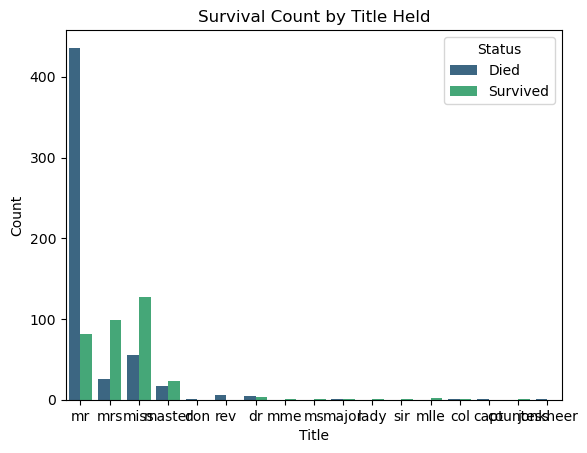

In [8]:
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].str.lower()

n = df.groupby('Title')['Survived']
print(f"Percentage of survivals per title held: \n {n.mean() * 100}")

sns.countplot(x='Title', hue='Survived', data=df, palette='viridis')

plt.title('Survival Count by Title Held')
plt.xlabel('Title')
plt.ylabel('Count')
plt.legend(title='Status', labels=['Died', 'Survived']) 

df.drop(columns=['Name'], inplace=True)

As we can see by this, the survival rate varies immensely between titles and so this feature must be useful. Most of the titles, however, have a very low number of occurences and so should be replaced with a unique name so future models wont be confused with all the names.

In [9]:
print(df.value_counts('Title'))

df['Title'] = df['Title'].replace(['lady', 'countess','capt', 'col',\
 	'don', 'dr', 'major', 'rev', 'sir', 'jonkheer', 'dona'], 'Rare')

Title
mr          517
miss        182
mrs         125
master       40
dr            7
rev           6
major         2
col           2
mlle          2
mme           1
ms            1
capt          1
lady          1
jonkheer      1
don           1
countess      1
sir           1
Name: count, dtype: int64


In [10]:
print(f" Data Types: \n{df.dtypes}")

print(f" NA values per column: \n{df.isna().sum()}")
print(f"Total of rows: {df.shape}")

 Data Types: 
PassengerId      int64
Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
Title           object
dtype: object
 NA values per column: 
PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
Title            0
dtype: int64
Total of rows: (891, 10)


Now, for Sex, Embarked and Title, who have only some possible values, we can encode them without increasing the dimensionality a lot.

We can also simply impute the Embarked most frequent value in the nan, since theyre only 2 rows. 

In [11]:
imputer_embarked = SimpleImputer(strategy='most_frequent')
df['Embarked'] = imputer_embarked.fit_transform(df[['Embarked']]).ravel()
categorical_cols = ['Sex', 'Embarked', 'Title']

ct = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, ), categorical_cols)
], remainder='passthrough', verbose_feature_names_out=False) 

ct.set_output(transform='pandas')
train_encoded = ct.fit_transform(df)

train_encoded.head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Rare,Title_master,Title_miss,Title_mlle,Title_mme,Title_mr,Title_mrs,Title_ms,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,3,22.0,1,0,7.2500
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1,1,38.0,1,0,71.2833
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,1,3,26.0,0,0,7.9250
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,1,1,35.0,1,0,53.1000
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5,0,3,35.0,0,0,8.0500


Now, we still have 177 nan rows in age which is quite significant considering the total number of rows is 889!

Let's analyze better what can be inputed in these rows so that they are still used by our model.

There are many methods of imputation to be considered. The mean/median imputation is one of the most common. But for it to be the most adequate, the imputed variable should not be very highly correlated with any other variable, or some bias may arise. 

Let's check correlations then:

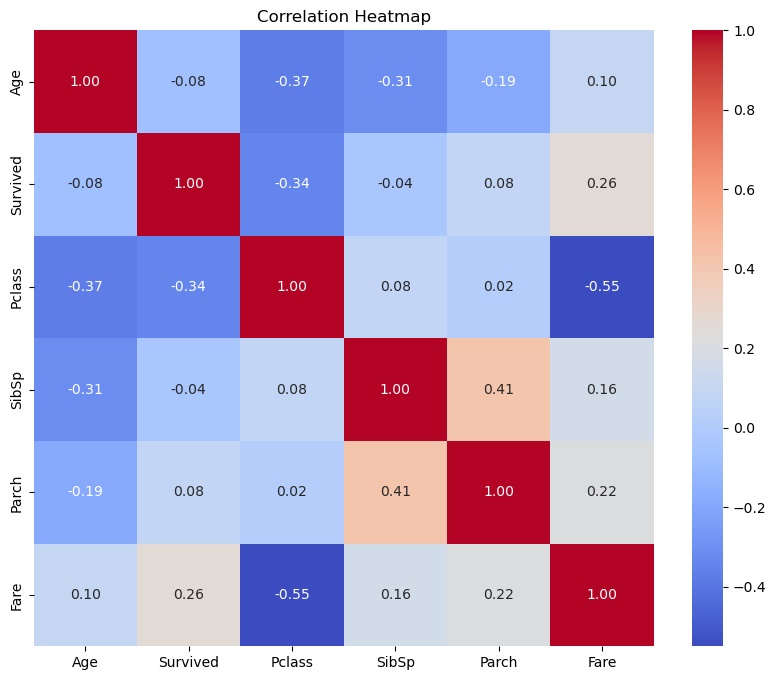

In [12]:
cols_to_check = ['Age', 'Survived', 'Pclass', 'SibSp', 'Parch', 'Fare']
corr_matrix = train_encoded[cols_to_check].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

There's some correlation between Age and Pclass/SibSp. The negative correlation indicates that as these grow (meaning, as the class is higher and the number of siblings and spouses goes up), the age tends to be smaller. So, younger people were generally in the 3rd/2nd classes and had more family members aboard.

One possible tatic to input in the data is the kNN. This method will take into account other characteristics of the missing Age rows, like Fare and Sex and will give an Age guess based on other similar passengers. Since this is a small dataset aswell, this technique won't be too computationally expensive. 

*Note:* Since knn is distance based, we should scale the numeric features so they don't overpower/are overpowered.

In [13]:
cols_to_scale = ['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']

scaler = StandardScaler()
train_scaled = train_encoded.copy()
train_scaled[cols_to_scale] = scaler.fit_transform(train_encoded[cols_to_scale])

if 'PassengerId' in train_scaled.columns: #dropping this so it doesnt mess with calculations
    train_scaled.drop(columns=['PassengerId'], inplace=True)


imputer = KNNImputer(n_neighbors=5)
train_imputed = pd.DataFrame(imputer.fit_transform(train_scaled), columns=train_scaled.columns, index=train_scaled.index)

#back to normal scale

train_imputed[cols_to_scale] = scaler.inverse_transform(train_imputed[cols_to_scale])
train_results = train_imputed.pop('Survived')

train_imputed.head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Rare,Title_master,Title_miss,Title_mlle,Title_mme,Title_mr,Title_mrs,Title_ms,Pclass,Age,SibSp,Parch,Fare
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,22.0,1.0,0.0,7.2500
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,38.0,1.0,0.0,71.2833
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,26.0,0.0,0.0,7.9250
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,35.0,1.0,0.0,53.1000
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,35.0,0.0,0.0,8.0500


Let's remember that this should all be repicable so that we can apply it to the testing data later on. Let's then create a pipeline that combains all this engineering.

In [14]:
def create_title(df):
    
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    
    df['Title'] = df['Title'].str.lower()
    
    
    rare = ['lady', 'countess','capt', 'col', 'don', 'dr', 
                     'major', 'rev', 'sir', 'jonkheer', 'dona']
    
    df['Title'] = df['Title'].replace(rare, 'rare')
    df['Title'] = df['Title'].replace(['mlle', 'ms'], 'miss')
    df['Title'] = df['Title'].replace('mme', 'mrs')
    

    df['Title'] = df['Title'].fillna('missing')
    
    return df

train = create_title(train)
test = create_title(test)

#separating columns by type
num_cols = ['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']
cat_cols = ['Sex', 'Embarked']

#for numeric columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

#for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop', 
    verbose_feature_names_out=False
).set_output(transform='pandas')

pipeline_cleaning = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer_knn', KNNImputer(n_neighbors=5))
])

Because we don't have the test data real results, we can separate the training data into 2 parts, one consisting of 80% of data to train the model and 20% to validate our results. We'll also apply our pipeline to make sure our data is all consistent.

In [15]:
#let's make sure it is consistent

X = train.drop(columns=['Survived'])
y = train['Survived']

X_t, X_v, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = pipeline_cleaning.fit_transform(X_t) #to train

X_test = pipeline_cleaning.transform(X_v) #to validate (test) in here 

X_test_processed = pipeline_cleaning.transform(test)  # to submite in kaggle



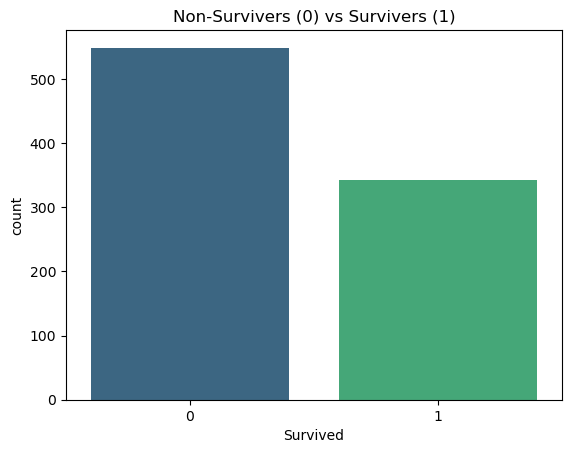

In [16]:

sns.countplot(x='Survived',hue='Survived', legend=False, data=train, palette='viridis')
plt.title("Non-Survivers (0) vs Survivers (1)")
plt.show()

#pretty balanced dataset, that's good

Sex
female    314
male      577
Name: Survived, dtype: int64
Percentage of survivals per gender: 
 Sex
female    74.203822
male      18.890815
Name: Survived, dtype: float64


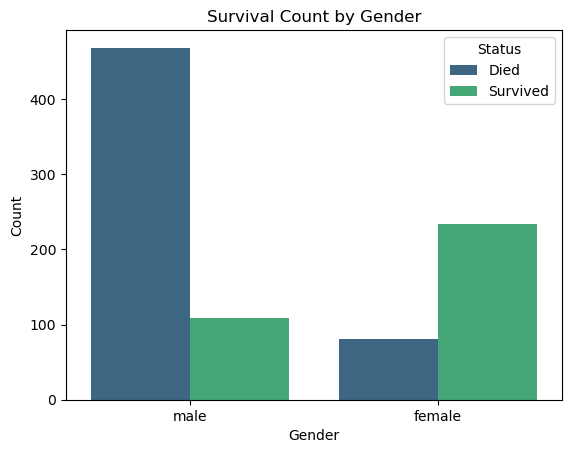

In [17]:
n = train.groupby('Sex')['Survived']
print(n.size())
print(f"Percentage of survivals per gender: \n {n.mean() * 100}")

sns.countplot(x='Sex', hue='Survived', data=train, palette='viridis')

plt.title('Survival Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Status', labels=['Died', 'Survived']) 
plt.show()

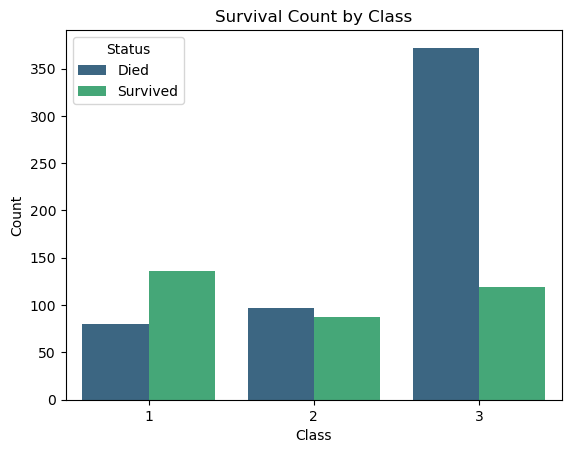

Percentage of survivors per class: 
 Pclass
1    62.962963
2    47.282609
3    24.236253
Name: Survived, dtype: float64
Percentage of passengers per class: 
 Pclass
1    24.242424
2    20.650954
3    55.106622
dtype: float64


In [18]:
sns.countplot(x='Pclass', hue='Survived', data=train, palette='viridis')

plt.title('Survival Count by Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend(title='Status', labels=['Died', 'Survived']) 
plt.show()

print(f"Percentage of survivors per class: \n {train.groupby('Pclass')['Survived'].mean() *100}")

print(f"Percentage of passengers per class: \n {train.groupby('Pclass').size()/  train.shape[0] * 100}")

Interesting that even though the 3rd class made up more than half of the passengers, they still have the lowest survival percentage. 

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_21552\3422365814.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=train, x='Age', fill=True, common_norm=False, palette='viridis')


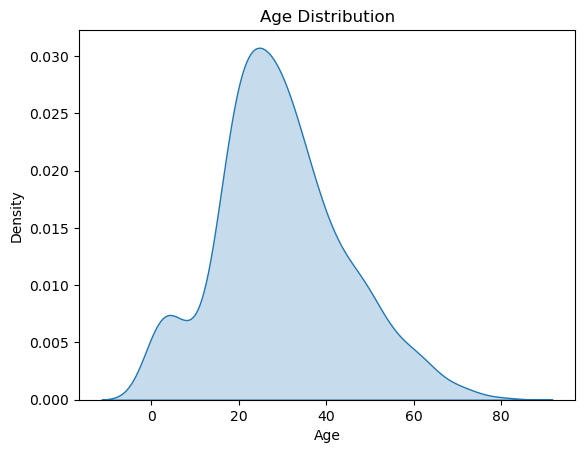

In [19]:
sns.kdeplot(data=train, x='Age', fill=True, common_norm=False, palette='viridis')

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

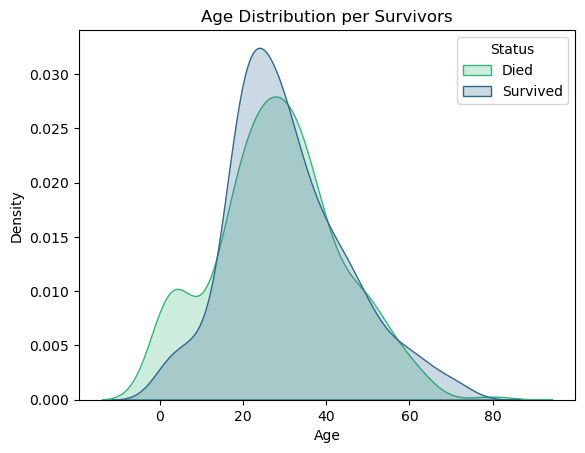

In [20]:
sns.kdeplot(data=train, x='Age', hue='Survived', fill=True, common_norm=False, palette='viridis')

plt.title('Age Distribution per Survivors')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend(title='Status', labels=['Died', 'Survived'])
plt.show()

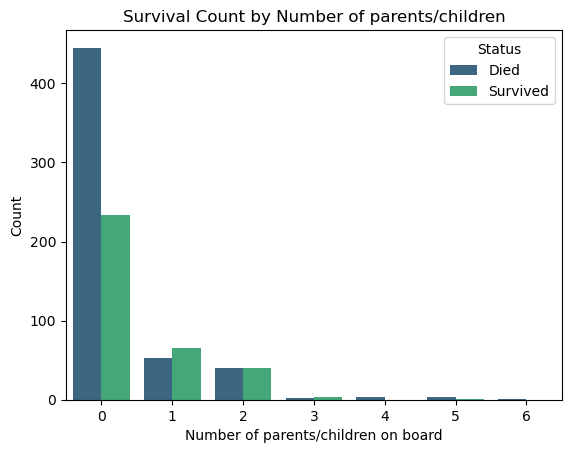

Count of people with different parents/children number: 
 Parch
0    678
1    118
2     80
3      5
4      4
5      5
6      1
dtype: int64
Percentage of survivors per number: 
 Parch
0    34.365782
1    55.084746
2    50.000000
3    60.000000
4     0.000000
5    20.000000
6     0.000000
Name: Survived, dtype: float64
Percentage of passengers per number: 
 Parch
0    76.094276
1    13.243547
2     8.978676
3     0.561167
4     0.448934
5     0.561167
6     0.112233
dtype: float64


In [21]:
sns.countplot(x='Parch', hue='Survived', data=train, palette='viridis')

plt.title('Survival Count by Number of parents/children')
plt.xlabel('Number of parents/children on board')
plt.ylabel('Count')
plt.legend(title='Status', labels=['Died', 'Survived']) 
plt.show()

print(f"Count of people with different parents/children number: \n {train.groupby('Parch').size()}")

print(f"Percentage of survivors per number: \n {train.groupby('Parch')['Survived'].mean() *100}")

print(f"Percentage of passengers per number: \n {train.groupby('Parch').size()/  train.shape[0] * 100}")

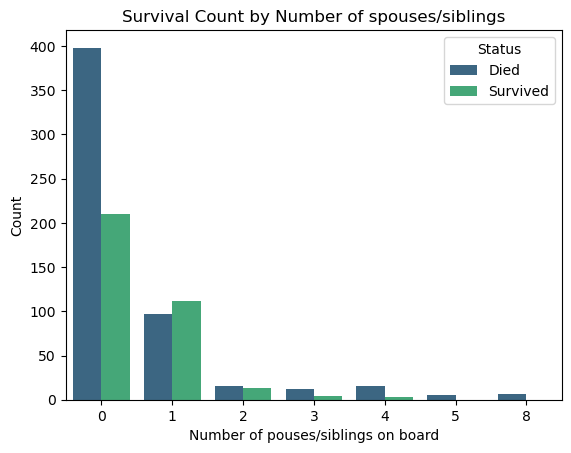

Count of people with different parents/children number: 
 SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
dtype: int64
Percentage of survivors per number: 
 SibSp
0    34.539474
1    53.588517
2    46.428571
3    25.000000
4    16.666667
5     0.000000
8     0.000000
Name: Survived, dtype: float64
Percentage of passengers per numer: 
 SibSp
0    68.237935
1    23.456790
2     3.142536
3     1.795735
4     2.020202
5     0.561167
8     0.785634
dtype: float64


In [22]:
sns.countplot(x='SibSp', hue='Survived', data=train, palette='viridis')

plt.title('Survival Count by Number of spouses/siblings')
plt.xlabel('Number of pouses/siblings on board')
plt.ylabel('Count')
plt.legend(title='Status', labels=['Died', 'Survived']) 
plt.show()

print(f"Count of people with different parents/children number: \n {train.groupby('SibSp').size()}")

print(f"Percentage of survivors per number: \n {train.groupby('SibSp')['Survived'].mean() *100}")

print(f"Percentage of passengers per numer: \n {train.groupby('SibSp').size()/  train.shape[0] * 100}")

For the big number of children/parents, since there's so little cases, the results should not be very explanatory.  


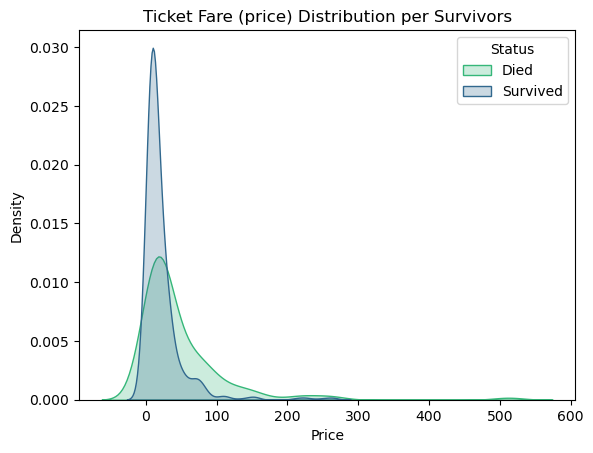

In [23]:
sns.kdeplot(data=train, x='Fare', hue='Survived', fill=True, common_norm=False, palette='viridis')

plt.title('Ticket Fare (price) Distribution per Survivors')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend(title='Status', labels=['Died', 'Survived'])
plt.show()

Embarked
C    168
Q     77
S    644
Name: Survived, dtype: int64
Percentage of survivals per embarkment location: 
 Embarked
C    55.357143
Q    38.961039
S    33.695652
Name: Survived, dtype: float64


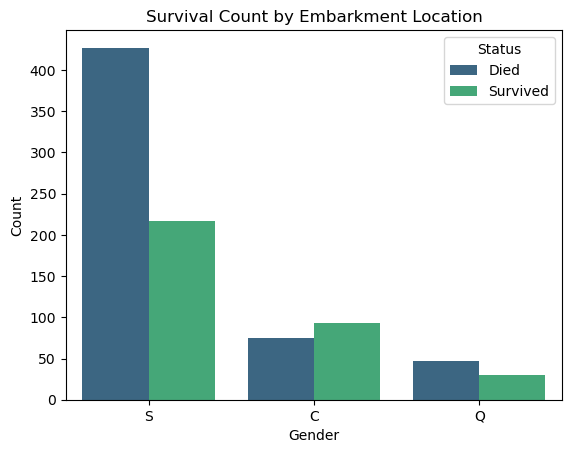

In [24]:
n = train.groupby('Embarked')['Survived']
print(n.size())
print(f"Percentage of survivals per embarkment location: \n {n.mean() * 100}")

sns.countplot(x='Embarked', hue='Survived', data=train, palette='viridis')

plt.title('Survival Count by Embarkment Location')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Status', labels=['Died', 'Survived']) 
plt.show()


Let's remember that this is a classification task! So, how can it be approached?

### Logistic Regression

This algorithm tries to model the classification of the different events (in this case, passengers) by finding an equation that separates the two variables, using the predictive attribute values. So, in this case, this model will find numerical parameters where we can apply the different values of Pclass, Age, Fare, etc... and get the output on a 0-1 scale. We'll assume that, if the value is bigger than 0.5, then the passenger is predicted as having survived and, otherwise, has not having survived. 

In [25]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)


LogisticRegression()

Now, to evaluate the model there are amany ways to do it!
The standard measure is accuracy, which just computed the percentage of correct predictions. But that is a very generic measure, that may be affected by the training datasets imbalance. This is not the case here but still, it'd be interesting to get a more detailed insight into the model performance. As we said before, the model actually predicts a probability and not the real binary classification... So, we can actually use those probability values (that are between 0 and 1) to compute the ROC curve, which gives us information on how the model performs for different threshold values (different than 50%).

Log model estimated accuracy: 81.56%


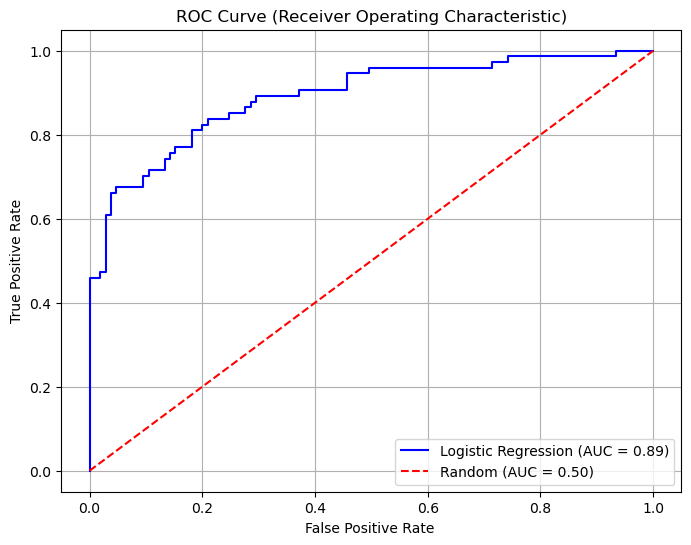

In [26]:
log_val_predictions = log_model.predict(X_test)
log_accuracy= accuracy_score(y_test, log_val_predictions)

print(f"Log model estimated accuracy: {log_accuracy:.2%}")

#Let's get the probabilities values so that we can compute the ROC
y_probs = log_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Logistic Regression (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random (AUC = 0.50)')
plt.title('ROC Curve (Receiver Operating Characteristic)')
plt.xlabel('False Positive Rate ')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


#testing predictions to submit 
log_pred = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': log_model.predict(X_test_processed)})
log_pred.to_csv('log_prediction.csv', index=False)

The closer the area under the curve is to 1, the better the model is! So, in this case, both the accuracy and ROC measures nicely evaluate this model.

After submiting, the score acquired was 0.7655 so there's room for improvement! Let's try other models.

### KNN (K-Nearest Neighbors)

Since predictions are still made, this algorithm can sometimes be called a model, although it is not one in the traditional sense. There's no training required since it makes decisions based on the training data when it’s time to predict.

Basically, the idea is that, for each prediction, the 'model' will look at the training data and find the K nearest neighbours, meaning, the cases where the predictive attributes are the most similar (based on distance metrics) and output the correspondent neighbors classification by taking a majority vote. 

The hyperparameter of the K number of neighbours necessary is not that simple to determine. But on this case, since our data doesn't take that long to train, we'll test different values to try and find the one with the best cross validation score. 

Text(0, 0.5, 'Accuracy Score')

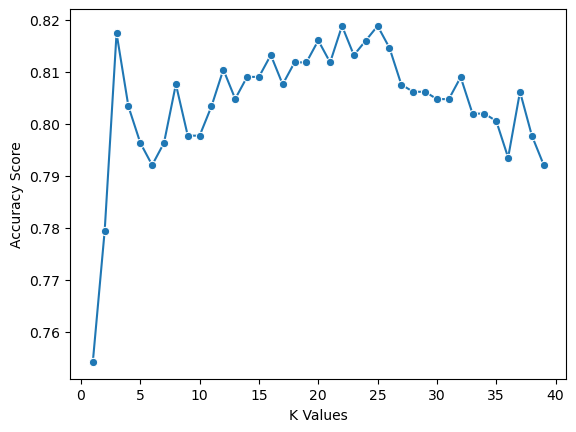

In [27]:
k_values = [i for i in range (1,40)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=5)
    scores.append(np.mean(score))

sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [28]:
best_index = np.argmax(scores)
best_k = k_values[best_index]

knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=25)

Knn model estimated accuracy: 79.89%


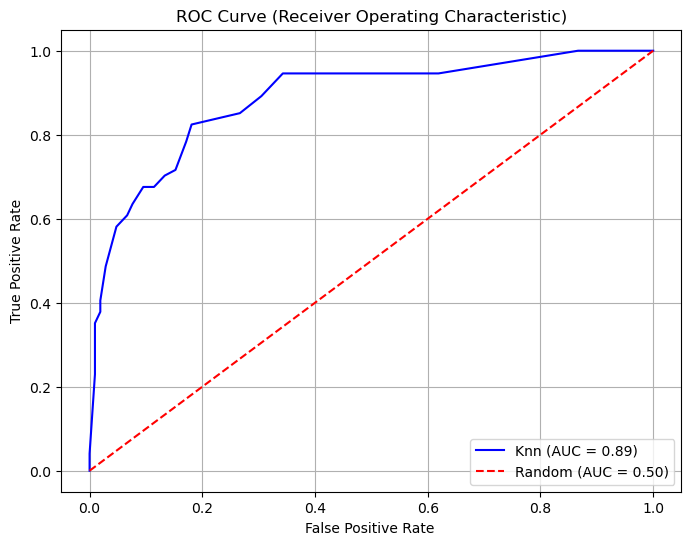

In [29]:
knn_val_predictions = knn_model.predict(X_test)
knn_accuracy= accuracy_score(y_test, knn_val_predictions)

print(f"Knn model estimated accuracy: {knn_accuracy:.2%}")

#Let's get the probabilities values so that we can compute the ROC
knn_y_probs = knn_model.predict_proba(X_test)[:, 1]

knn_fpr, knn_tpr, thresholds = roc_curve(y_test, knn_y_probs)
knn_auc_score = roc_auc_score(y_test, knn_y_probs)


plt.figure(figsize=(8, 6))
plt.plot(knn_fpr, knn_tpr, color='blue', label=f'Knn (AUC = {knn_auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random (AUC = 0.50)')
plt.title('ROC Curve (Receiver Operating Characteristic)')
plt.xlabel('False Positive Rate ')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


#testing predictions to submit 
knn_pred = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': knn_model.predict(X_test_processed)})
knn_pred.to_csv('knn_prediction.csv', index=False)

In this case, the submission accuracy was 0.76076, so actually lower than logistic regression. 

### Decision Tree

(from https://scikit-learn.org/stable/modules/tree.html )- Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

So, the model will look through the data and constantly try to find splits (separations) that minimize impurity/maximize entropy in the results (nodes) of that same separation. It will continue to do so for all nodes, creating branches that lead into purer nodes until some condition is met (target impurity value/ number of nodes). For Random Trees to work well, they should be used in problems whose main question's answer can be given if we know the answer to another series of questions.  


In [30]:
dt_model = tree.DecisionTreeClassifier()

dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

Dt model estimated accuracy: 82.12%


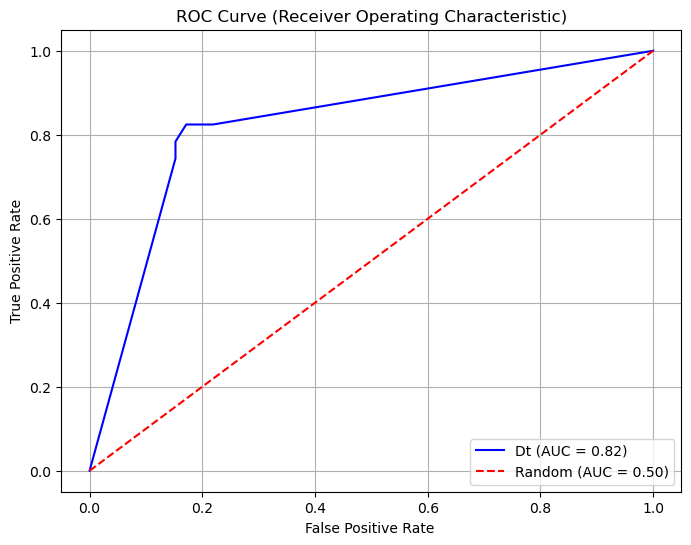

In [31]:
dt_val_predictions = dt_model.predict(X_test)
dt_accuracy= accuracy_score(y_test, dt_val_predictions)

print(f"Dt model estimated accuracy: {dt_accuracy:.2%}")

#Let's get the probabilities values so that we can compute the ROC
dt_y_probs = dt_model.predict_proba(X_test)[:, 1]

dt_fpr, dt_tpr, thresholds = roc_curve(y_test, dt_y_probs)
dt_auc_score = roc_auc_score(y_test, dt_y_probs)


plt.figure(figsize=(8, 6))
plt.plot(dt_fpr, dt_tpr, color='blue', label=f'Dt (AUC = {dt_auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random (AUC = 0.50)')
plt.title('ROC Curve (Receiver Operating Characteristic)')
plt.xlabel('False Positive Rate ')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


#testing predictions to submit 
dt_pred = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': dt_model.predict(X_test_processed)})
dt_pred.to_csv('dt_prediction.csv', index=False)

We can see that this model's results have a better accuracy than the ones before but a worst AUC.  

When submitting in the competition, this actually gave a lower score of 0.74641! This proves that, in this specific case, the accuracy alone cannot be used as a direct measurement of the model's quality. 

### Random Forest

Up until now, we've only used individual models, that take the training data, use it to construct its algorithm, and based on that give new results on testing data.

But what if we wanted to take it a step further, and not take just one model's 'opinion' into account, but several? This is exactly what *ensemble model* does! This technique improves generalizability / robustness over a single estimator.

Random Forets are a type of ensemble model, made up of many decision trees. Each tree is trained on a different data sample (thanks to bootstraping techniques) as well as a select number of features, making the trees different and so improving the overall estimate. 

We can also do a Grid Search to look for the best parameters to use, that'll give us the best results:


In [32]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

# We'll test these:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)


grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best Scores: {grid_search.best_score_:.4f}")

best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Scores: 0.8300


Now, using the model with the best parameters, we can compute more insights:

Random Forest model estimated accuracy: 81.56%


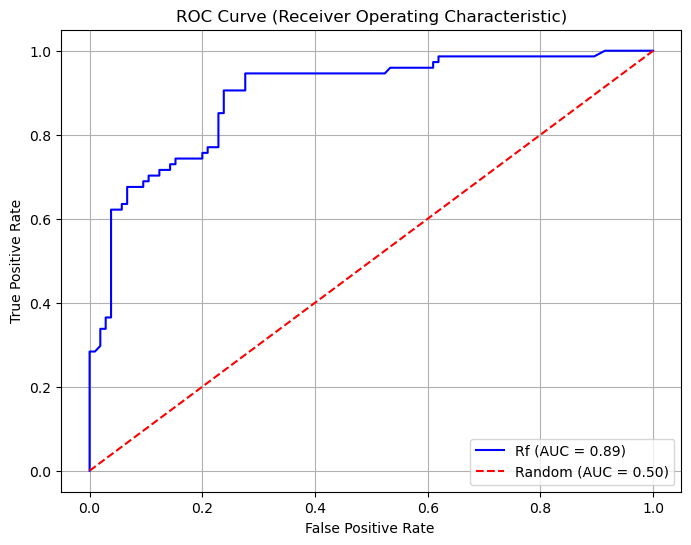

In [33]:
rf_val_predictions = best_rf.predict(X_test)
rf_accuracy= accuracy_score(y_test, rf_val_predictions)

print(f"Random Forest model estimated accuracy: {rf_accuracy:.2%}")

#Let's get the probabilities values so that we can compute the ROC
rf_y_probs = best_rf.predict_proba(X_test)[:, 1]

rf_fpr, rf_tpr, thresholds = roc_curve(y_test, rf_y_probs)
rf_auc_score = roc_auc_score(y_test, rf_y_probs)


plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, color='blue', label=f'Rf (AUC = {rf_auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random (AUC = 0.50)')
plt.title('ROC Curve (Receiver Operating Characteristic)')
plt.xlabel('False Positive Rate ')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


#testing predictions to submit 
rf_pred = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': best_rf.predict(X_test_processed)})
rf_pred.to_csv('rf_prediction.csv', index=False)

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_21552\1548774725.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


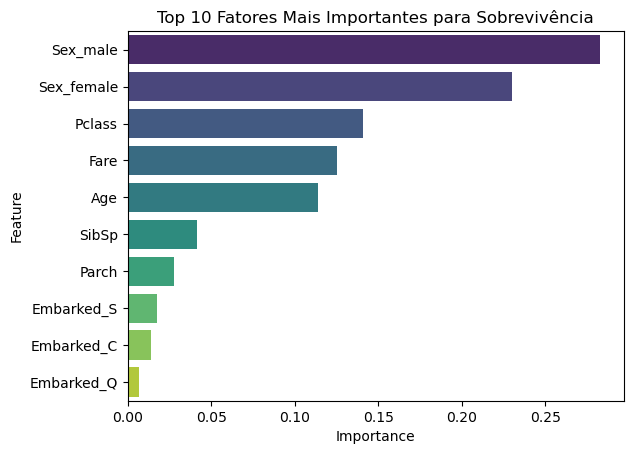

In [ ]:
# Buscar a importância das features do modelo treinado
importances = best_rf.feature_importances_

# Buscar os nomes das colunas que saíram do pipeline
# (Nota: Pode variar dependendo da versão do sklearn, mas geralmente é assim)
feature_names = pipeline_cleaning.get_feature_names_out() 

# Criar DataFrame e ordenar
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Top 10 Fatores Features for Survival')
plt.show()

The submissions' score was of 0.76076.

### XGBoost (Extreme Gradient Boosting)
Just like Random Forest, XGBoost is an ensemble method based on decision trees. However, the strategy it uses to combine these trees is fundamentally different.

While Random Forest builds many trees independently at the same time and averages their results (a technique called Bagging), XGBoost builds trees sequentially (a technique called Boosting). This means that each new tree is created specifically to correct the errors made by the previous trees. The model focuses on the "hard-to-predict" cases, trying to reduce the error (gradient) with each step.

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=100, 
    objective='binary:logistic', 
    tree_method='hist', 
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

XGBoost model estimated accuracy: 82.12%


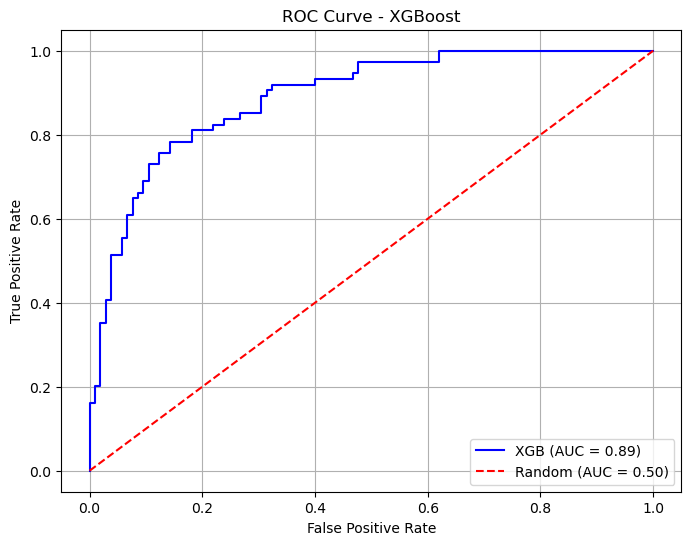

In [ ]:
xgb_predictions = xgb_model.predict(X_test)

xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f"XGBoost model estimated accuracy: {xgb_accuracy:.2%}")

xgb_y_probs = xgb_model.predict_proba(X_test)[:, 1]

# 6. Calcular métricas ROC
xgb_fpr, xgb_tpr, thresholds = roc_curve(y_test, xgb_y_probs)
xgb_auc_score = roc_auc_score(y_test, xgb_y_probs)

#
plt.figure(figsize=(8, 6))
plt.plot(xgb_fpr, xgb_tpr, color='blue', label=f'XGB (AUC = {xgb_auc_score:.2f})') # <--- CORRIGIDO AQUI
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random (AUC = 0.50)')
plt.title('ROC Curve - XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


#testing predictions to submit 
xgb_pred = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': xgb_model.predict(X_test_processed)})
xgb_pred.to_csv('xgb_prediction.csv', index=False)

Competition accuracy was 0.73444. 